# Detect text regions using MMOCR Detection

In [1]:
# python env mmocr_env
from mmocr.apis import MMOCRInferencer
# only text region detection
ocr_det = MMOCRInferencer(det='DBNetpp', rec=None, device='cuda:0')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth
09/28 21:38:51 - mmengine - WARNING - Failed to search registry with scope "mmocr" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmocr" is a correct scope, or whether the registry is initialized.


C:\PROJECTS\OCR\mmocr_env\Lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

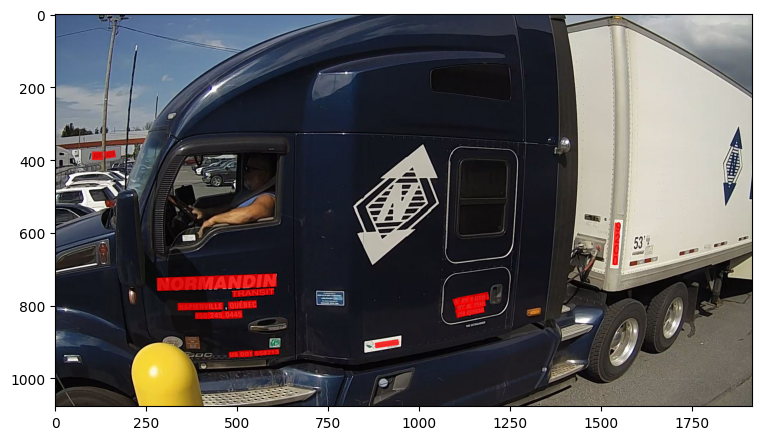

In [15]:
IMAGE_PATH = "C:/PROJECTS/OCR/images/full2.JPG"

CLUESTER_INTER_SAPCE = 60.0

result = ocr_det(IMAGE_PATH, out_dir='outputs/', return_vis=True, save_pred=False, save_vis=True)

# Visualize the results
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 16))
plt.imshow(result['visualization'][0])
plt.show()

In [16]:
import json
#print(json.dumps(result["predictions"][0], sort_keys=True, indent=4))

import cv2
import pytesseract
import numpy as np
from sklearn.cluster import DBSCAN

# Filter low score detected polygons
def filter_polygons(polygons, scores, threshold):
    filtered_polygons = []
    for polygon, score in zip(polygons, scores):
        if score >= threshold:
            filtered_polygons.append(polygon)
    return filtered_polygons

# Convert polygons to bounding boxes
def poly_to_bbox(poly):
    x_coords = poly[0::2]
    y_coords = poly[1::2]
    return (min(x_coords), min(y_coords), max(x_coords), max(y_coords))

#convert polygons to bboxes
def polys_to_bboxes(polys):
    bboxes = [poly_to_bbox(poly) for poly in polys]
    return bboxes

# merge grouped bounding boxes
def merge_bboxes(bboxes, min_dist):
    # Extract center points of bounding boxes
    center_points = [[(bbox[0] + bbox[2]) / 2.0, (bbox[1] + bbox[3]) / 2.0] for bbox in bboxes]
    # Convert the list of center points to a numpy array
    center_points_array = np.array(center_points)
    
    # Use DBSCAN from scikit-learn to cluster center points
    clustering = DBSCAN(eps=min_dist, min_samples=1).fit(center_points_array)
    labels = clustering.labels_
    
    merged_bboxes = []
    for label in set(labels):
        idxs = np.where(labels == label)[0]
        clustered_bboxes = [bboxes[i] for i in idxs]

        # Merge bounding boxes in each cluster
        x_min = min([bbox[0] for bbox in clustered_bboxes])
        y_min = min([bbox[1] for bbox in clustered_bboxes])
        x_max = max([bbox[2] for bbox in clustered_bboxes])
        y_max = max([bbox[3] for bbox in clustered_bboxes])

        merged_bboxes.append([x_min, y_min, x_max, y_max])

    return merged_bboxes

def draw_polygons(img, polygons):
    img2 = cv2.copyTo(img, None)
    for polygon in polygons:
        # Reshape the polygon points and convert them to int32
        pts = np.array(polygon).reshape((-1, 2)).astype(np.int32)
        # Draw the polygon on the image
        cv2.polylines(img2, [pts], isClosed=True, color=(0, 255, 0), thickness=3)
    cv2.imshow('Image with Polygons', img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def draw_bboxes(img, bboxes):
    img2 = cv2.copyTo(img, None)
    for bbox in bboxes:
        # Extract coordinates
        x_min, y_min, x_max, y_max = map(int, bbox)
        # Draw bounding box on the image
        cv2.rectangle(img2, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=3)
    # Display the image
    cv2.imshow('Image with Bounding Boxes', img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    


In [17]:

polygons= result["predictions"][0]["det_polygons"]
scores= result["predictions"][0]["det_scores"]

# Load the image with OpenCV
img = cv2.imread(IMAGE_PATH)
# all detected polygons
draw_polygons(img, polygons)
# filtering polygons
polygons = filter_polygons(polygons, scores, threshold = 0.8)
draw_polygons(img, polygons)

# all boxes
bboxes = polys_to_bboxes(polygons)
draw_bboxes(img, bboxes)

# merge bboxes
merged_bboxes = merge_bboxes(bboxes, min_dist=CLUESTER_INTER_SAPCE)
draw_bboxes(img, merged_bboxes)


# Recognize text from regions using MMOCR

In [18]:
ocr_rec = MMOCRInferencer(det=None, rec='MASTER', device='cuda:0')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/master/master_resnet31_12e_st_mj_sa/master_resnet31_12e_st_mj_sa_20220915_152443-f4a5cabc.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



C:\PROJECTS\OCR\mmocr_env\Lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [19]:
from PIL import Image

def mmocr_horizontal_text_from_image(img, show_images, only_digits):
    height, width = img.shape[:2]
    # Binarization
    #_, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    
    # In case there are close-by digits, you can optionally dilate the image to separate them
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #img_bin = cv2.dilate(img_bin, kernel, iterations=1)
    
    # Perform opening: erosion followed by dilation
    #kernel = np.ones((5,5), np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    #img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
    
    # Display the ROI using OpenCV
    if (show_images):        
        cv2.imshow('Opened Image', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    numpy_array_image = np.array(img)
    result = ocr_rec(numpy_array_image, return_vis=False, save_pred=False, save_vis=False)
    #print(result)
    # Visualize the results
    #import matplotlib.pyplot as plt
    #plt.figure(figsize=(9, 16))
    #plt.imshow(result['visualization'][0])
    #plt.show()
    if len(result['predictions']) > 0:
        return result['predictions'][0]['rec_texts'][0], result['predictions'][0]['rec_scores'][0]
    return "", 0.

def mmocr_vertical_text_from_image(img, show_images, only_digits):
    height, width = img.shape[:2]
    
    # Binarization
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_bin = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY_INV)
    
    # In case there are close-by digits, you can optionally dilate the image to separate them
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #img_bin = cv2.dilate(img_bin, kernel, iterations=1)
    
    # Perform opening: erosion followed by dilation
    #kernel = np.ones((5,5), np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    #img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
    
    # Display the ROI using OpenCV
    if (show_images):        
        cv2.imshow('Opened Image', img_bin)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Detect the contours of the digits
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Display contours
    if (show_images and False):
        img_with_contours = img.copy()  # Create a copy of the original image
        cv2.drawContours(img_with_contours, contours, -1, (255, 255, 255), 2)  # Draw all contours
        cv2.imshow('Image with Contours', img_with_contours)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    digits = []
    scores = []
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # skip small countours
        if w < 10 or h < 10 or w > 100 or h > 100:
            continue        
        
        # Extract the region of interest (ROI) containing the digit
        MARGIN = 6
        roi = img[max(0, y - MARGIN):min(height, y + h + MARGIN), max(0, x - MARGIN):min(width, x + w + MARGIN)]
        # Display the ROI using OpenCV
        if (show_images):
            cv2.imshow('ROI Image', roi)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            
        numpy_array_image = np.array(roi)
        result = ocr_rec(numpy_array_image, return_vis=False, save_pred=False, save_vis=False)
        if len(result['predictions']) > 0:
            text = result['predictions'][0]['rec_texts'][0]
            score = result['predictions'][0]['rec_scores'][0]
            #print(f"vertical char: {text}, score: {score}")
            digits.append((y, text))  # Save the digit with its y-coordinate
            scores.append(score)

    # Sort the digits based on their y-coordinates (top-to-bottom)
    sorted_digits = sorted(digits, key=lambda x: x[0])
    
    # Extract just the digit values (discard the y-coordinates)
    text = [digit[1] for digit in sorted_digits]
    
    return ''.join(text), np.mean(scores)


In [20]:
img = cv2.imread(IMAGE_PATH) # 0 means grayscale
#cv2.imshow('Image', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
    
height, width = img.shape[:2]
# extract image of the detected region
for bbox in merged_bboxes:
    # Extract coordinates
    x_min, y_min, x_max, y_max = map(int, bbox)
    w = x_max - x_min
    h = y_max -y_min
    # process only vertical
    aspect_ratio = w/h
   
    # Extract the region of interest (ROI) containing the digit
    MARGIN = 5
    roi_img = img[max(0, y_min - MARGIN):min(height, y_max + MARGIN), max(0, x_min - MARGIN):min(width, x_max + MARGIN)]
    #cv2.imshow('ROI Image', roi_img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    print(f"{w}x{h} -> {aspect_ratio}")
    digits = ""
    if aspect_ratio < 0.3: 
        # vertical
        #if w < 80:
            digits, score = mmocr_vertical_text_from_image(roi_img, show_images=True, only_digits=False)
            print(f"vertical code: {digits}, score: {score}")
    else:
        #if aspect_ratio > 2.5:
            # horizontal
            if h < 80 and w < 250:
                digits, score = mmocr_horizontal_text_from_image(roi_img, show_images=False, only_digits=False)
                print(f"horizontal code: {digits}, score: {score}")

Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

vertical code: 92100, score: 0.8222020417451859
64x25 -> 2.56


horizontal code: NORTHMATIC, score: 0.6913553506135941


# Recognize text from regions using Tesseract

In [11]:
import pytesseract
from PIL import Image

def get_horizontal_text_from_image(img, show_images, only_digits):
    height, width = img.shape[:2]
    # Binarization
    #_, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    
    # In case there are close-by digits, you can optionally dilate the image to separate them
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #img_bin = cv2.dilate(img_bin, kernel, iterations=1)
    
    # Perform opening: erosion followed by dilation
    #kernel = np.ones((5,5), np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    #img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
    
    # Display the ROI using OpenCV
    if (show_images):        
        cv2.imshow('Opened Image', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    digits = []
    
    config = '--psm 10'
    if only_digits:
        config += ' -c tessedit_char_whitelist=0123456789'

    text = pytesseract.image_to_string(img, config=config)
    return text

def get_vertical_text_from_image(img, show_images, only_digits):
    height, width = img.shape[:2]
    
    # Binarization
    _, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    
    # In case there are close-by digits, you can optionally dilate the image to separate them
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #img_bin = cv2.dilate(img_bin, kernel, iterations=1)
    
    # Perform opening: erosion followed by dilation
    #kernel = np.ones((5,5), np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    #img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
    
    # Display the ROI using OpenCV
    if (show_images):        
        cv2.imshow('Opened Image', img_bin)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Detect the contours of the digits
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Display contours
    if (show_images and False):
        img_with_contours = img.copy()  # Create a copy of the original image
        cv2.drawContours(img_with_contours, contours, -1, (255, 255, 255), 2)  # Draw all contours
        cv2.imshow('Image with Contours', img_with_contours)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    digits = []
    
    config = '--psm 10'
    if only_digits:
        config += ' -c tessedit_char_whitelist=0123456789'

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # skip small countours
        if w < 10 or h < 10 or w > 100 or h > 100:
            continue        
        
        # Extract the region of interest (ROI) containing the digit
        MARGIN = 6
        roi = img_bin[max(0, y - MARGIN):min(height, y + h + MARGIN), max(0, x - MARGIN):min(width, x + w + MARGIN)]
        
        # Convert the ROI to a PIL Image (needed for pytesseract)
        roi_img = Image.fromarray(roi)
        
        # Display the ROI using OpenCV
        if (show_images and False):
            cv2.imshow('ROI Image', roi)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        
        # Get the text from the ROI
        
        text = pytesseract.image_to_string(roi_img, config=config)
        #print(text)
        digits.append((y, text.strip()))  # Save the digit with its y-coordinate

    # Sort the digits based on their y-coordinates (top-to-bottom)
    sorted_digits = sorted(digits, key=lambda x: x[0])
    
    # Extract just the digit values (discard the y-coordinates)
    result = [digit[1] for digit in sorted_digits]
    
    return ''.join(result)

In [12]:
img = cv2.imread(IMAGE_PATH, 0) # 0 means grayscale
#cv2.imshow('Image', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
    
height, width = img.shape[:2]
# extract image of the detected region
for bbox in merged_bboxes:
    # Extract coordinates
    x_min, y_min, x_max, y_max = map(int, bbox)
    w = x_max - x_min
    h = y_max -y_min
    # process only vertical
    aspect_ratio = w/h
   
    # Extract the region of interest (ROI) containing the digit
    MARGIN = 5
    roi_img = img[max(0, y_min - MARGIN):min(height, y_max + MARGIN), max(0, x_min - MARGIN):min(width, x_max + MARGIN)]
    #cv2.imshow('ROI Image', roi_img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    print(f"{w}x{h} -> {aspect_ratio}")
    if aspect_ratio < 0.3: 
        # vertical
        if w < 80:
            digits = get_vertical_text_from_image(roi_img, show_images=True, only_digits=False)
            print(f"vertical code: {digits}")
    else:
        if aspect_ratio > 2.5:
            # horizontal
            if h < 80 and w < 250:
                digits = get_horizontal_text_from_image(roi_img, show_images=True, only_digits=False)
                print(f"horizontal code: {digits}")
    
        

NameError: name 'merged_bboxes' is not defined